# Анализ оттока клиентов банка 

## Описание проекта и задач 

**Общая информация:** датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Основная задача:** проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка, для отдела маркетинга с процентом отточных клиентов выше, чем по всему датасету и размером не менее 500-600 пользователей (сегменты могут пересекаться).

Для ее выполнения проведем исследовательский анализ данных, определим значимые признаки отточности, сформулируем и проверим статистические гипотезы. Объединяя признаки отточности, сформируем сегменты, отберем из них лучшие и дадим по ним рекомендации.

**Описание столбцов датасета:**

- user_id — идентификатор пользователя,
- score — баллы кредитного скоринга,
- сity — город,
- gender — пол,
- age — возраст,
- equity — количество баллов собственности,
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — активный ли клиент,
- est_salary — заработная плата клиента,
- churn — ушёл или нет.

## Загрузка данных и изучение общей информации  

In [1]:
#импортируем нужные библиотеки
#!pip install phik
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import phik
from phik import resources, report
import scipy.stats as stats
import itertools

#! pip install kaleido
import kaleido

#также отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/shepe/Downloads/bank_metanprom.csv')

In [3]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
#создадим функцию для первичного анализа датафрейма и подсчета явных дубликатов

def df_analyse(df):
    dupl = df.duplicated().sum()
    nan = df.isna().sum()
    
    print(f'Кол-во NaN:{nan}')
    print(f'Явных дубликатов:{dupl}')
    display(df.head(5)), 
    display (df.info()),
    display (df.describe());

In [5]:
df_analyse(data)

Кол-во NaN:USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64
Явных дубликатов:0


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


None

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


Благодаря функции первичного анализа мы увидели, что в датасете **есть пропуски в двух столбцах** (age и balance).

Явных дубликатов в данных **не обнаружено**.

В некоторых столбцах ('score', 'age', 'equity', 'products', 'credit_card', 'last_activity', 'churn') данные хранятся не совсем оптимально — на этапе предобработки исправим это.

Также мы видим, что **в данных есть аномалии** (возраст, баланс и зарплата). Они могут отразиться на результатах исследования, поскольку мы будем применять статистические тесты и выяснять корреляции. Выбросы в столбце с возрастом оставим без изменений (в соответствии с задачами исследования), в остальных столбцах проанализируем аномалии более детально на этапе предобработки.

## Предобработка данных 

### Переименование столбцов 

In [6]:
data = data.rename(columns = {'USERID':'user_id','EST_SALARY':'salary'})

### Заменим типы данных в столбцах для более оптимального хранения датасета

In [7]:
data = data.astype({'score':'float32',
                    'age':'float32', 
                    'equity':'int8',
                    'products':'int8',
                    'credit_card':'int8',
                    'last_activity':'int8',
                    'churn':'int8'})

### Обработка пропусков в столбцах balance и age ### 

С помощью функции первичной обработки датасета мы увидели, что пропуски есть в двух стоблцах: age и balance, причем в последнем это число значительно:

In [8]:
value = round(data['balance'].isna().sum()/data['balance'].count(),3)
f'Доля пропусков в столбце balance равна {value}'

'Доля пропусков в столбце balance равна 0.298'

**Это значительный процент пропусков, который может сильно повлиять на исследование. Попробуем выяснить, с чем могут быть связаны такие потери данных — технический это сбой или мы можем восстановить часть данных?**

Предположим, что пропуски в столбце с балансом у пользователей с нулевым балансом (логично, что при этом раскладе столбце мог быть просто не заполнен). Тогда в датасете не будут присутствовать пользователи, у которых баланс обозначен нулем.

In [9]:
data.query(" balance == 0 ")

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
3900,179831,730.0,Ярославль,М,18.0,0,0.0,2,1,1,64548.33,0
6757,148456,813.0,Ярославль,М,20.0,2,0.0,2,1,0,23876.51,0


В датасете есть 2 строки, где баланс значится как  нулевой, это сильно мало, учитывая весь объем данных. Тем не менее, оба пользователя из Ярославля. Это выглядит подозрительно. 

Но однозначно сказать, что пропуски = нули нельзя. Посмотрим, могут ли пропуски зависеть от других факторов и можем ли мы их заполнить по какой-то другой логике? 

In [10]:
#создадим срез с пропусками
balance_nan = data.query("balance.isna()")
balance_nan

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Ростов,М,38.0,0,NaN,1,0,0,171763.69,0
9984,125941,729.0,Ярославль,Ж,42.0,0,NaN,1,1,1,687538.70,0
9993,219924,884.0,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0


In [11]:
#посмотрим на распределение по городам
balance_nan.groupby('city',as_index=False).agg({'user_id':'count'})

,city,user_id
0,Ростов,235
1,Рыбинск,593
2,Ярославль,1467


Большая часть пользователей с пропусками из Ярославля.

In [12]:
#какие баллы собственности
balance_nan['equity'].value_counts()

0    2180
1     114
3       1
Name: equity, dtype: int64

In [13]:
#распределение по городам и баллам собственности
balance_nan.groupby(['city','equity'],as_index=False).agg(count = ('user_id','count'))

,city,equity,count
0,Ростов,0,226
1,Ростов,1,9
2,Рыбинск,0,569
3,Рыбинск,1,23
4,Рыбинск,3,1
5,Ярославль,0,1385
6,Ярославль,1,82


Большинство пользователей с пропущенными значениями баланса имеют показатель 0 в собственности.

In [14]:
#посмотрим их распределение по кол-ву продуктов
balance_nan.groupby('products',as_index=False).agg({'user_id':'count'})

,products,user_id
0,0,1
1,1,1950
2,2,315
3,3,29


При этом большинство таких пользователей — с одним продуктом.

In [15]:
#есть ли у них кредитная карта?
balance_nan.groupby(['credit_card'],as_index=False).agg({'user_id':'count'})

,credit_card,user_id
0,0,423
1,1,1872


In [16]:
#распределение по городам, кол-ву продуктов и наличию кредитной карты
balance_nan.groupby(['city','products','credit_card'],as_index=False).agg(count = ('user_id','count'))

,city,products,credit_card,count
0,Ростов,1,0,76
1,Ростов,1,1,126
2,Ростов,2,0,10
3,Ростов,2,1,21
4,Ростов,3,1,2
5,Рыбинск,0,0,1
6,Рыбинск,1,0,121
7,Рыбинск,1,1,368
8,Рыбинск,2,0,18
9,Рыбинск,2,1,79


In [17]:
#распределение по баллам собственности, кол-ву продуктов и наличию кредитной карты
balance_nan.groupby(['equity','products','credit_card'],as_index=False).agg(count = ('user_id','count'))

,equity,products,credit_card,count
0,0,1,0,337
1,0,1,1,1515
2,0,2,0,55
3,0,2,1,246
4,0,3,0,13
5,0,3,1,14
6,1,1,0,14
7,1,1,1,84
8,1,2,0,3
9,1,2,1,11


Самая большая группа пользователей с пропусками — без собственности с одним продуктом — кредитной картой. При этом однозначно утверждать что-либо о характере пропусков мы не можем (возможно, баланс нулевой, возможно пользователи ушли в минус и пр.). Также есть другие группы пользователей, где тяжело найти общую закономерность.

In [18]:
#наконец, посмотрим распределение по отточности
balance_nan.groupby(['churn'],as_index=False).agg({'user_id':'count'})

,churn,user_id
0,0,2282
1,1,13


Проверив распределение пользователей с пропусками в разрезе отточности, мы поняли, что на основную задачу исследования пропуски сильно не повлияют (большинство из них не отточные). Поэтому, **несмотря на некоторыне найденные взаимосвязи, трогать пропуски в столбце balance не будем**. 

**Для столбца age** (где кол-во пропусков минимально) удалим пропуски, не будем учитывать 26 записей (только одна из таких записей с отточным пользователем).

In [19]:
data.query('age.isna()')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


In [20]:
#удаляем пропуски из датасета
data = data[np.logical_not(data['age'].isna())]

### Проверка на дубликаты 

**С помощью функции первичного анализа датафрейма мы определили, что явных дубликатов в датасете нет. Посмотрим, есть ли неявные дубликаты в данных?**

Логичнее всего начать со столбца с уникальным номером пользователя и проверить, дублируются ли они (спойлер: не должны)

In [21]:
dupl_user_id = data.groupby('user_id',as_index=False).agg(count=('user_id','count')).query('count > 1')['user_id']

In [22]:
#посмотрим на пользователей с дублирующимся уникальным номером
data.query('user_id in @dupl_user_id').sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2302,220816,934.0,Рыбинск,Ж,74.0,5,1294285.39,3,1,0,95606.80,0
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1
4216,226719,903.0,Рыбинск,Ж,63.0,0,NaN,1,1,0,138582.58,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1


In [23]:
#проверим, есть ли в датасете дублирующиеся пользователи 
data[data.duplicated(['user_id','city','age'])]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn


Итак, у нас есть 50 пользователей, уникальный номер которых дублируется с другими пользователями (50 пар). Мы видим, что все эти пользователи — разные люди, из разных городов, разного возраста и т.д. Чтобы не терять этих пользователей, присвоим им новый уникальный id.

In [24]:
temp = data.query('user_id in @dupl_user_id').sort_values(by='user_id').drop_duplicates(['user_id'])

In [25]:
data = data[~data.index.isin(temp.index)]

In [26]:
temp['user_id'] = temp['user_id']*10

In [27]:
data = pd.concat([data, temp],axis=0,ignore_index=True)

Скрытых дубликатов не по идентификатору пользователя в датасете нет:

In [28]:
data[data.duplicated(['city','age','gender','salary','equity'])]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn


### Изучение аномалий в данных

**Изучим аномалии в столбце balance:**

In [29]:
np.quantile(data[np.logical_not(data['balance'].isna())]['balance'],.99)

4827211.159

99 процентов значений столбца лежит в пределах 4,8 млн, посмотрим на визуальное распределение баланса, построив боксплот:

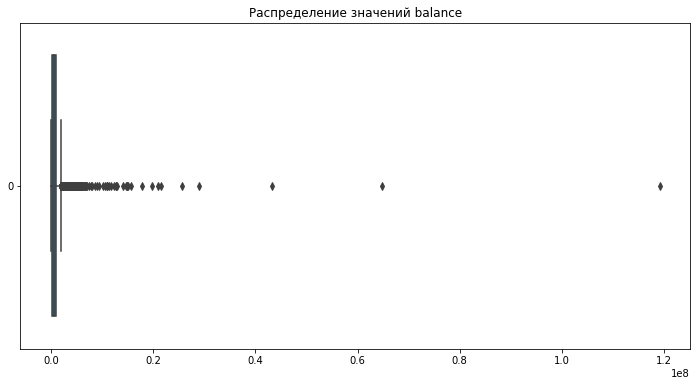

In [30]:
plt.figure(figsize = (12,6))
sns.boxplot(data['balance'], orient='h')
plt.title('Распределение значений balance');

Так как мы работаем с реальными данными, отсекать слишком высокие значения (более 99 перцентиля) не будем, так как нам важно посмотреть и на vip-клиентов в разрезе отточности.

Но можем здесь избавиться от совсем явных выбросов — по графику это примерно более 21 млн. Эти значения могут значительно повлиять на корректность статистических тестов, при этом для выделения сегментов отточных пользователей (нашей основной задачи) они сильно ничего не дадут. Так как мы только частично избавились от выбросов — учтем это при подсчете корреляции

In [31]:
#сколько значений мы потеряем
data.query('balance > 21000000')['balance'].count()

6

In [32]:
#обновим датасет
data = data.query('balance < 21000000 or balance.isna()')

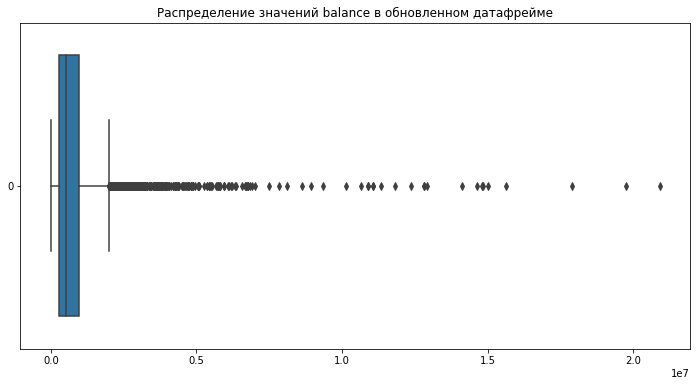

In [33]:
plt.figure(figsize = (12,6))
sns.boxplot(data['balance'], orient='h')
plt.title('Распределение значений balance в обновленном датафрейме');

**Изучим аномалии в столбце salary:**

In [34]:
np.quantile(data['salary'],.99)

882689.3667999996

99 процентов значений столбца лежат в пределах 882,7 тысяч

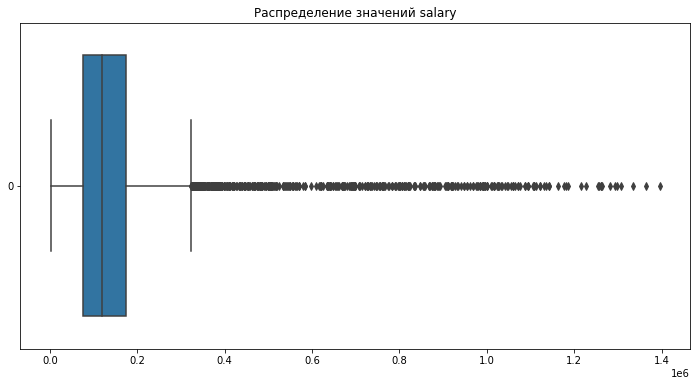

In [35]:
plt.figure(figsize = (12,6))
sns.boxplot(data['salary'], orient='h')
plt.title('Распределение значений salary');

В столбце с зарплатой мы также видим множество аномалий, также избавимся от самых явных выбросов. Визуально — более 1,2 млн рублей. 

In [36]:
data = data.query('salary < 1200000')

Столбец с зарплатой интересует еще с точки зрения аномально низких значений, посмотрим, много ли значений ниже МРОТ (16 242 рубля):

In [37]:
data.query("salary < 16242")['salary'].count()

80

Заменим значения ниже уровня МРОТ на минимальную зарплату в приведенных в датасете регионах: 

In [38]:
data.loc[data['salary'] < 16242,'salary'] = 16242

In [39]:
#после всех манипуляций проверим, сколько у нас осталось строк
data.shape[0]

9954

### Кодирование информации в столбцах gender и city

Для того чтобы корректно изучить корреляцию в дальнейшем, создадим вручную столбец с кодировкой пола, М — 0, Ж — 1:

In [40]:
data['gender_num'] =  0
data.loc[data["gender"] == "Ж",'gender_num'] = 1

Также создадим столбцы с кодировкой города:

In [41]:
data['city_2'] = data['city'] #создаем копию столбца city
data = pd.get_dummies(data,columns=['city'])

In [42]:
data = data.rename(columns = {'city_2':'city'}) #переименовываем столбец в изначальное имя, чтобы сохранить данные

In [43]:
data.head()

,user_id,score,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,gender_num,city,city_Ростов,city_Рыбинск,city_Ярославль
0,183012,850.0,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,Рыбинск,0,1,0
1,146556,861.0,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,Рыбинск,0,1,0
2,120722,892.0,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,Рыбинск,0,1,0
3,225363,866.0,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,1,Ярославль,0,0,1
4,157978,730.0,М,34.0,5,174.00,1,1,0,67353.16,1,0,Ярославль,0,0,1


### Дополнительно проверим данные на корректность (проверим, могли ли быть сбои в сборе данных)

Так как у нас есть довольно много пропусков, дубликты по уникальному номеру пользователя, было бы логично дополнительно проверить данные на корректность. Посмотрим, есть ли клиенты с 0 продуктов?

In [44]:
data.query('products == 0')['user_id'].count()

1

Удалим этого пользователя, поскольку пользователь без продуктов в банке — не клиент банка.

In [45]:
data = data.query('products > 0')

Несмотря на то, что такой клиент в датасете был только один и мы его удалили, хочется еще раз отметить, что определенные ошибки в формировании данных есть. 

**Необходимо выяснить природу пропусков (технический сбой или человеческий фактор),  а также понять, почему для разных пользователей возможно присваивание одного id.**

## Исследовательский анализ данных 

### Общий процент отточных клиентов всего датасета:

In [46]:
churn_rate = round(data[data['churn']== 1]['churn'].count()/data['churn'].count(),2)
churn_rate

0.18

18% отточных пользователей — довольно высокий показатель. Но это только общая цифра. Для того чтобы понять, какие сегменты пользователей более отточные, сначала проведем ИАД и рассмотрим, что влияет на отток.

### Какие признаки сильнее всего влияют на отток?  Проверим зависимость ухода клиента от факторов: пола, зарплаты, возраста, баланса на счете и т.д: вычислим корреляцию со столбцом churn, построим графики

Для начала построим общую матрицу корреляции переменных друг с другом. В основном нас интересует нахождение взаимосвязи с churn (показателем отточности), но также мы посмотрим на другие взаимосвязи для выявления возможных скрытых третьих переменных, влияющих на выявленные взаимосвязи с churn.

Для анализа взаимосвязи был выбран метод phik (на основе подсчета хи-квадрата). Несмотря на то, что в этом случае у нас не будет указаний на направление взаимосвязи (положительная она или отрицательная), учитывая характер наших данных, этот способ наиболее оптимальный. 

Почему не традиционная корреляция Пирсона? Во-первых, у нас далеко не все переменные количественные (например, самая основная — churn), во-вторых, распределение многих переменных не близко к нормальному.

In [47]:
#список из столбцов, между которыми можем посмотреть корреляцию
cor_list = ['churn','score', 'age', 'equity', 'balance',
                  'products', 'credit_card', 'last_activity', 'salary',
                  'gender_num', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль']

#формируем матрицу
phik_corr = data[cor_list].phik_matrix().sort_values(by='churn')

interval columns not set, guessing: ['churn', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'gender_num', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль']


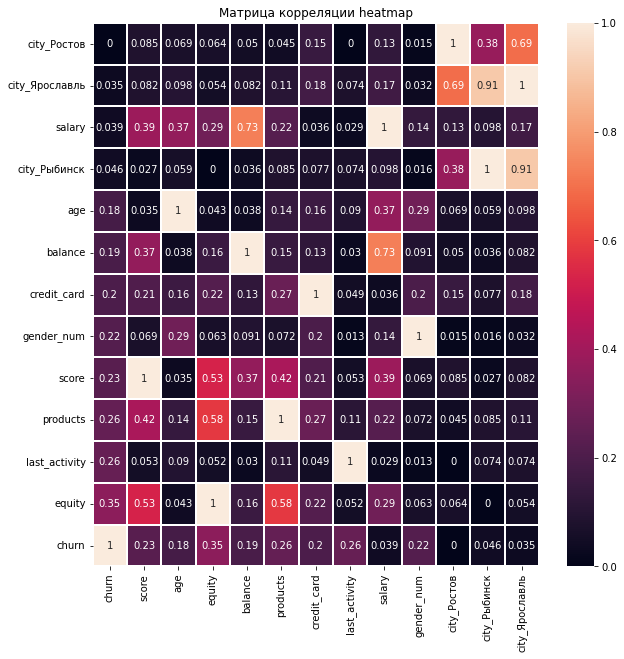

In [48]:
plt.figure(figsize=(10,10))

sns.heatmap(phik_corr, annot=True, linewidths=1, linecolor='white')
plt.title('Матрица корреляции heatmap')

plt.show();

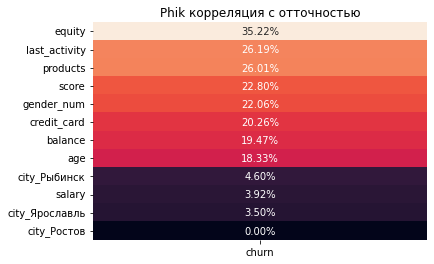

In [49]:
#отдельно посмотрим на интересующую нас более всего кор-цию с отточностью
sns.heatmap(phik_corr.loc[:,['churn']].drop('churn').sort_values('churn',ascending=False), fmt='.2%', annot=True, cbar=False)
plt.title('Phik корреляция с отточностью')

plt.show();

Сильной корреляции с churn нет ни у одной переменной, однако **наиболее выражена взаимосвязь с рейтингом собственности (0.35)**. 

Также довольно значительна связь с:

- products(0.26)
- last_activity(0.26)
- score(0.23)
- gender(0.22) 

Присутствует и корреляция отточности с наличием кредитной карты (0.2), балансом (0.19) и возрастом (0.18), но она менее выражена, чем с остальными параметрами.

С помощью общей матрицы корреляции мы выявили достаточно сильную взаимосвязь баланса и зарплаты (0.73). 

Также кредитный рейтинг достаточно сильно взаимосвязан с балансом (0.37), зарплатой (0.39), рейтингом собственности (0.53) и кол-вом продуктов (0.42). Соответственно, можно предположить, что корреляция рейтинга и отточности в некоторой степени связана с третьими переменными (рейтинг собственности, кол-во продуктов).

interval columns not set, guessing: ['churn', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'gender_num', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль']


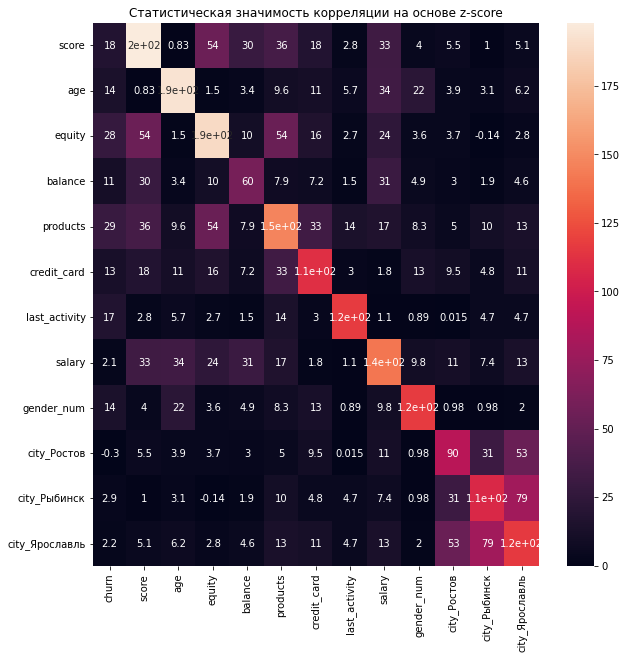

In [50]:
#проверим стат.значимость
phik_significance = data[cor_list].significance_matrix()

plt.figure(figsize=(10,10))

sns.heatmap(phik_significance.drop('churn'), annot=True)
plt.title('Статистическая значимость корреляции на основе z-score')

plt.show();

Все найденные взаимосвязи, кроме city_Ростов, с отточностью статистически значимы при уровне значимости в 0.05 (здесь коэффициент показывает кол-во сигм, соответственно, оно должно быть меньше двух, тогда мы не отвергаем нулевую гипотезу об отсутствии статистически значимой взаимосвязи).

При понижении уровня значимости до 0.01 связь с зарплатой, city_Рыбинск и city_Ярославль перестала бы быть статистически значимой.

**Дополнительно проверим наличие взаимосвязи переменных и статистическую значимость взаимосвязи**

Разделим наши переменные на две группы: интервальные и все остальные. Для первых вычислим  биссериальный коэффициент (а churn как дихотомическая), для остальных используем хи-квадрат.

In [51]:
#вычислим точечно-бисериальную корреляцию (биссериальный коэффициент) и значимость для churn и интервальных переменных
numeric = ['products','score','salary','balance','age']
alpha = 0.05 #уровень стат.значимости

for i in numeric:
    mask = data[i].notna()
    p_value = stats.pointbiserialr(x= data.loc[mask, 'churn'], y= data.loc[mask, i])[1]
    print(f'Корреляция и статистическая значимость корреляции отточности и {i}')
    print(stats.pointbiserialr(data.loc[mask, 'churn'], data.loc[mask, i]))
    
    if p_value<alpha:
        print('Отвергаем нулевую гипотезу об отсутствии взаимосвязи, взаимосвязь с churn статистически значима')
    else:
        print('Не удалось отвергнуть нулевую гипотезу, взаимосвязь с churn статистически не значима')
    print()

Корреляция и статистическая значимость корреляции отточности и products
PointbiserialrResult(correlation=0.30176844880331377, pvalue=1.273144585647711e-208)
Отвергаем нулевую гипотезу об отсутствии взаимосвязи, взаимосвязь с churn статистически значима

Корреляция и статистическая значимость корреляции отточности и score
PointbiserialrResult(correlation=0.10668389331025774, pvalue=1.3700939664401018e-26)
Отвергаем нулевую гипотезу об отсутствии взаимосвязи, взаимосвязь с churn статистически значима

Корреляция и статистическая значимость корреляции отточности и salary
PointbiserialrResult(correlation=0.00607549089697626, pvalue=0.5444821270853273)
Не удалось отвергнуть нулевую гипотезу, взаимосвязь с churn статистически не значима

Корреляция и статистическая значимость корреляции отточности и balance
PointbiserialrResult(correlation=0.17253528645821997, pvalue=2.067784272349312e-52)
Отвергаем нулевую гипотезу об отсутствии взаимосвязи, взаимосвязь с churn статистически значима

Коррел

С помощью этого метода мы также нашли взаимосвязи с churn, они статистически значимы при pvalue в 0.05, кроме корреляции со столбцом salary. 

Взаимосвязь products с отточностью данный способ показывает как наиболее сильную среди других интервальных переменных (0.3), на втором месте balance (0.17), phik выявил довольно сильную связь с кредитным рейтингом и балансом, однако биссериальный коэффициент этого не показывает. 

Также интересно, что корреляция с возрастом — отрицательная, более того, она ничтожно мала.

**Проверим значимость для остальных переменных с помощью Хи-квадрата:**

In [52]:
for value in data[['equity', 
       'credit_card', 'last_activity', 'gender_num', 
       'city_Ростов', 'city_Рыбинск', 'city_Ярославль']]:
    chi_2, p_value, d_fr, array = stats.chi2_contingency(pd.crosstab(data['churn'], data[value]))
    print (f' Для столбца {value} уровень значимости {p_value}')
    
    if p_value<alpha:
        print('Отвергаем нулевую гипотезу, взаимосвязь с churn статистически значима')
    else:
        print('Не удалось отвергнуть нулевую гипотезу, взаимосвязь с churn статистически не значима')
        
    print()

 Для столбца equity уровень значимости 1.8241471644315497e-152
Отвергаем нулевую гипотезу, взаимосвязь с churn статистически значима

 Для столбца credit_card уровень значимости 1.303362414955111e-38
Отвергаем нулевую гипотезу, взаимосвязь с churn статистически значима

 Для столбца last_activity уровень значимости 9.065948652706239e-64
Отвергаем нулевую гипотезу, взаимосвязь с churn статистически значима

 Для столбца gender_num уровень значимости 1.6532276539714528e-45
Отвергаем нулевую гипотезу, взаимосвязь с churn статистически значима

 Для столбца city_Ростов уровень значимости 0.6482632167772434
Не удалось отвергнуть нулевую гипотезу, взаимосвязь с churn статистически не значима

 Для столбца city_Рыбинск уровень значимости 0.001991496005626474
Отвергаем нулевую гипотезу, взаимосвязь с churn статистически значима

 Для столбца city_Ярославль уровень значимости 0.014813878416559156
Отвергаем нулевую гипотезу, взаимосвязь с churn статистически значима



Тест подтвердил, что найденные взаимосвязи, кроме city_Ростов, с отточностью статистически значимы.

### Распределение активности пользователя

In [53]:
#установка палитры
sns.set_palette('Set2')

#функция построения графика плотности распрделения параметра в зависимости от отточности
def var_analysis(data, column, bins=100):
    
    if bins != 2:

        fig = px.histogram(data, 
                   x=column,
                   color='churn', 
                   nbins=bins, 
                   barmode='overlay',
                   histnorm='probability density',
                    color_discrete_sequence=px.colors.qualitative.Set2
                  ) 

        fig.update_layout(title=f'Распределение {column} в зависимости от отточности', 
                   title_font=dict(size=21))
        fig.update_xaxes(title_text=column,title_font=dict(size=16))
        fig.update_yaxes(title_text='Плотность величины',title_font=dict(size=16))
        fig.show(renderer='png', scale = None) #настроим отображение в формате png

#распределение для бинарных 
    else:
        df = data.pivot_table(index = column, columns = 'churn', values ='user_id',aggfunc = 'count').reset_index()
        df.columns = [column,'уходящие','неуходящие']
        
        df['sum1'] = df['уходящие'].sum()
        df['sum0'] = df['неуходящие'].sum()
        df['уходящие'] = df['уходящие']/df['sum1']
        df['неуходящие'] = df['неуходящие']/df['sum0']
        df = df.drop(['sum0','sum1'],axis=1)
        
        ax = df.plot(x=column,kind='barh',stacked= False,figsize=(12,6) )

        plt.title(f'Распределение {column} в зависимости от отточности',fontsize=19)
        plt.xlabel('Плотность',fontsize=14)
        plt.ylabel(column,fontsize=14)

        plt.grid (axis='x',alpha=0.5)
        plt.show();

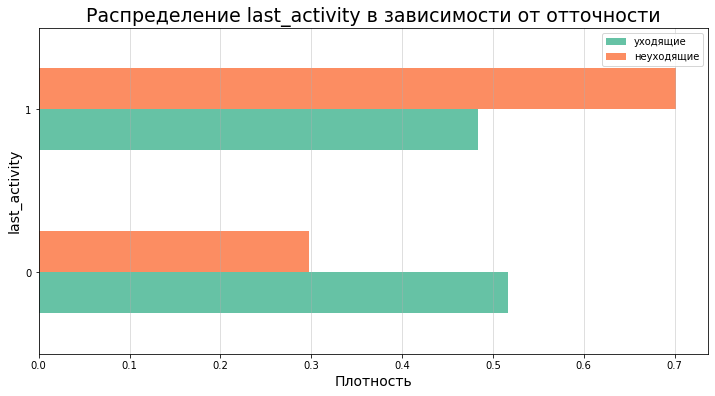

In [54]:
var_analysis(data, 'last_activity',2)

Наиболее склонны к отточности клиенты, которые совершали хотя бы одну активность в течение месяца (70%). Можно предположить, что это клиенты, которые более ответственно относятся к использованию продуктов/более финансово ответственны и склонны управлять своими банковскими продуктами, выбирать более выгодные предложения.

Среди неотточных больше клиентов (51.6%), которые активности не совершали — возможно, это люди, у которых открыто несколько счетов в разных банках и вклад в нашем банке — либо накопительный, либо неосновной, либо не используется, но клиент не особенно управляет своими счетами и не склонен закрывать их в случае неиспользования.

### Распределение кредитного рейтинга

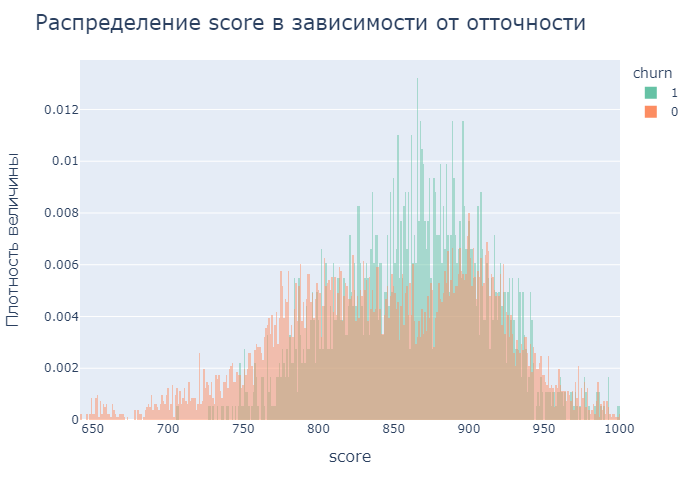

In [55]:
var_analysis(data, 'score',500)

У отточных пользователей в среднем выше кредитный рейтинг (наиболее частое значение — 866, чаще всего на промежутке от 850 до 900).

Учитывая график и ориентируясь на наиболее частотные значения у отточных пользователей, выделим следующие категории: **'менее 820 баллов включительно', '820-900 баллов', '901-950 баллов', 'высокий — более 950 баллов'**.

Учитывая ранее выявленные корреляции (кредитный рейтинг достаточно сильно взаимосвязан с балансом (0.37), зарплатой (0.39), рейтингом собственности (0.53) и кол-вом продуктов (0.31)), можно предположить, что он складывается с учетом этих показателей. 

И опять же, скорее всего влияет на отточность не сам рейтинг как таковой, а скорее его составляющие. Также вероятно, что есть третья скрытая переменная, которая не учитывается в данных. Например, что пользователи с более высоким доходом более ответственно и внимательно подходят к финансовым вопросам, больше следят за используемыми банковскими продуктами в целом.

Также зная, что рейтинг коррелирует с зарплатой, балансом и оценкой собственности, можно предположить, что и при распределении этих показателей у отточных сдвиг графика будет правее, чем у неотточных.

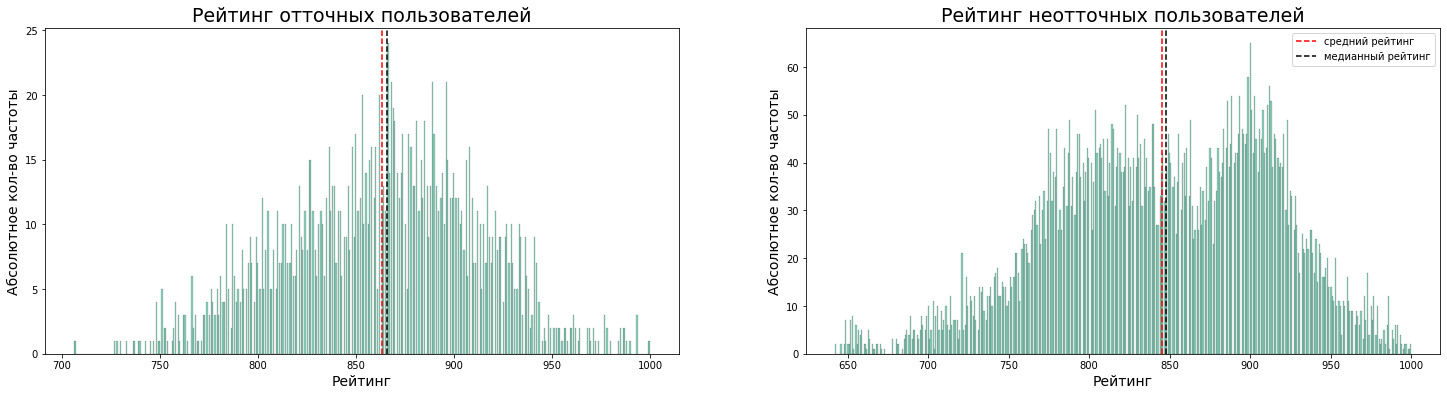

In [56]:
true_churn = data.query('churn == 1')
false_churn = data.query('churn == 0')

fig, (ax1, ax2) = plt.subplots(1,ncols = 2,figsize=(25,6))

ax1 = sns.histplot(x='score',data=true_churn, bins = 500, ax=ax1)
ax1.set_title('Рейтинг отточных пользователей',fontsize=19)
ax1.set_xlabel('Рейтинг',fontsize=14)
ax1.set_ylabel('Абсолютное кол-во частоты',fontsize=14)
ax1.axvline(x=true_churn['score'].mean(), color='r', linestyle='--',label="средний рейтинг")
ax1.axvline(x=true_churn['score'].median(), color='k', linestyle='--',label="мединный рейтинг")

ax2 = sns.histplot(x='score', data=false_churn,bins = 500, ax=ax2)
ax2.set_title('Рейтинг неотточных пользователей',fontsize=19)
ax2.axvline(x=false_churn['score'].mean(), color='r', linestyle='--',label="средний рейтинг")
ax2.axvline(x=false_churn['score'].median(), color='k', linestyle='--',label="медианный рейтинг")


plt.xlabel('Рейтинг',fontsize=14)
plt.ylabel('Абсолютное кол-во частоты',fontsize=14)

plt.legend()
plt.show()

### Распределение по полу

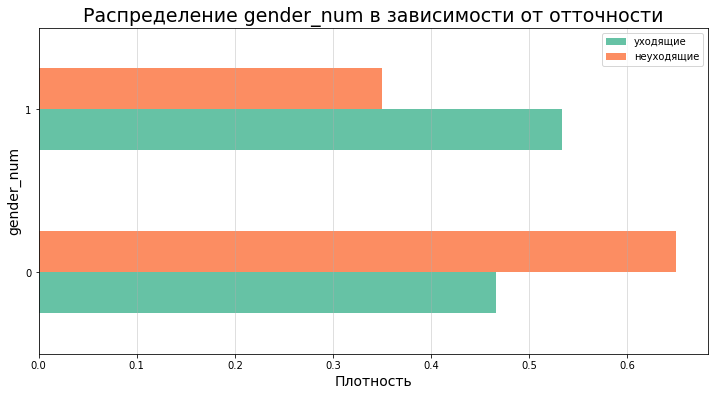

In [57]:
var_analysis(data, 'gender_num', 2)

К отточности более склонны мужчины (65% отточных — мужчины). В то время как доля женщин среди отточных ниже. И наоборот, среди неотточных больше женщин (53%). 

### Распределение по возрасту

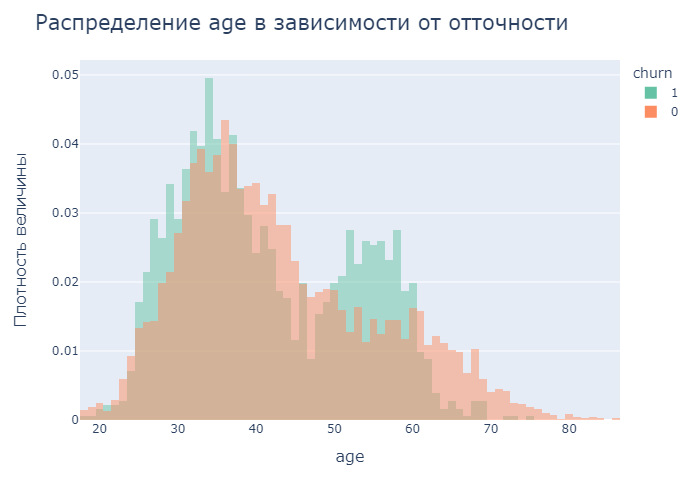

In [58]:
var_analysis(data, 'age')

Среди отточных мы видим две наиболее распространенные возрастные группы с высокой долей отточности — 25-35 лет и 50-60 лет.

У неотточных возраст распределен более равномерно, самая пиковая группа — 36 лет, есть небольшой всплеск плотности в районе 48-52 и 60-61 лет. Доля неотточных больше у пользователей 36-49 лет и 60+.

Учитывая график и ориентируясь на наиболее частотные значения у отточных пользователей, выделим следующие категории: **'молодежь до 25 лет', 'зрелая молодежь 25-35 лет', 'люди среднего возраста 36-50 лет', 'средне-старший возраст 51-60 лет', 'старший возраст более 60+ лет'.**

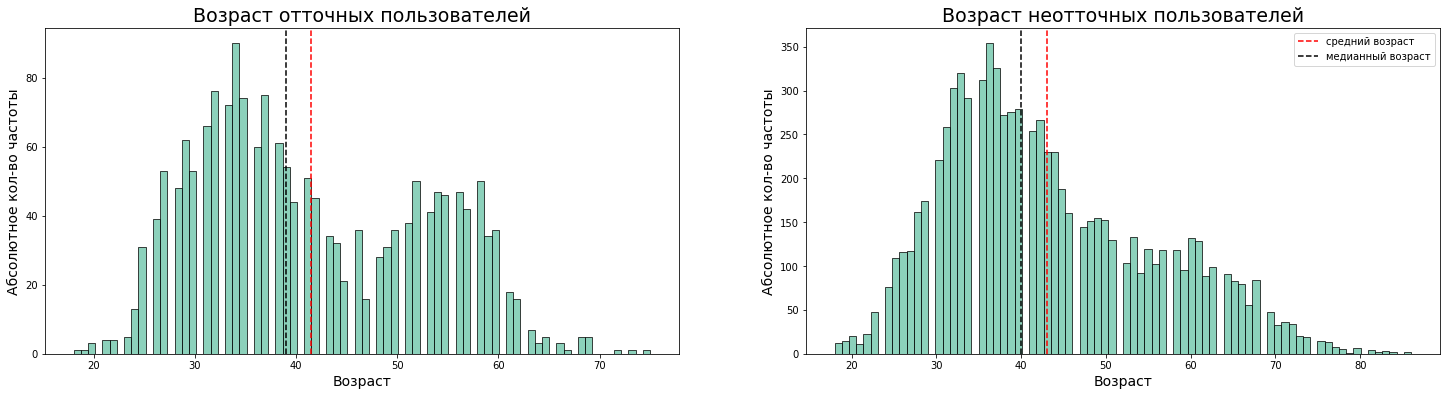

In [59]:
fig, (ax1, ax2) = plt.subplots(1,ncols = 2,figsize=(25,6))

ax1 = sns.histplot(x='age',data=true_churn, bins = 80, ax=ax1)
ax1.set_title('Возраст отточных пользователей',fontsize=19)
ax1.set_xlabel('Возраст',fontsize=14)
ax1.set_ylabel('Абсолютное кол-во частоты',fontsize=14)
ax1.axvline(x=true_churn['age'].mean(), color='r', linestyle='--',label="средний возраст")
ax1.axvline(x=true_churn['age'].median(), color='k', linestyle='--',label="мединный возраст")

ax2 = sns.histplot(x='age', data=false_churn,bins = 80, ax=ax2)
ax2.set_title('Возраст неотточных пользователей',fontsize=19)
ax2.axvline(x=false_churn['age'].mean(), color='r', linestyle='--',label="средний возраст")
ax2.axvline(x=false_churn['age'].median(), color='k', linestyle='--',label="медианный возраст")
ax2.set_xlabel('Возраст',fontsize=14)
ax2.set_ylabel('Абсолютное кол-во частоты',fontsize=14)

plt.legend()
plt.show()

### Распределение по количеству продуктов

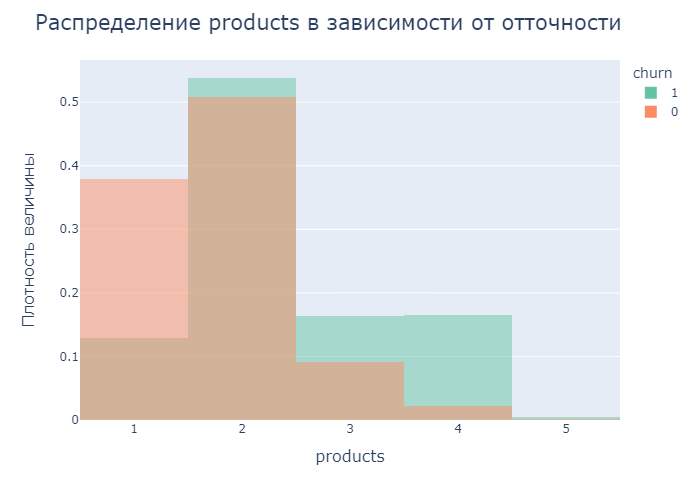

In [60]:
var_analysis(data, 'products',5)

In [61]:
# добавим функцию для показа значений столбца
def show_values(axs, n, space=.02):
    def _single(ax):
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = round(p.get_height(),n)
                ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

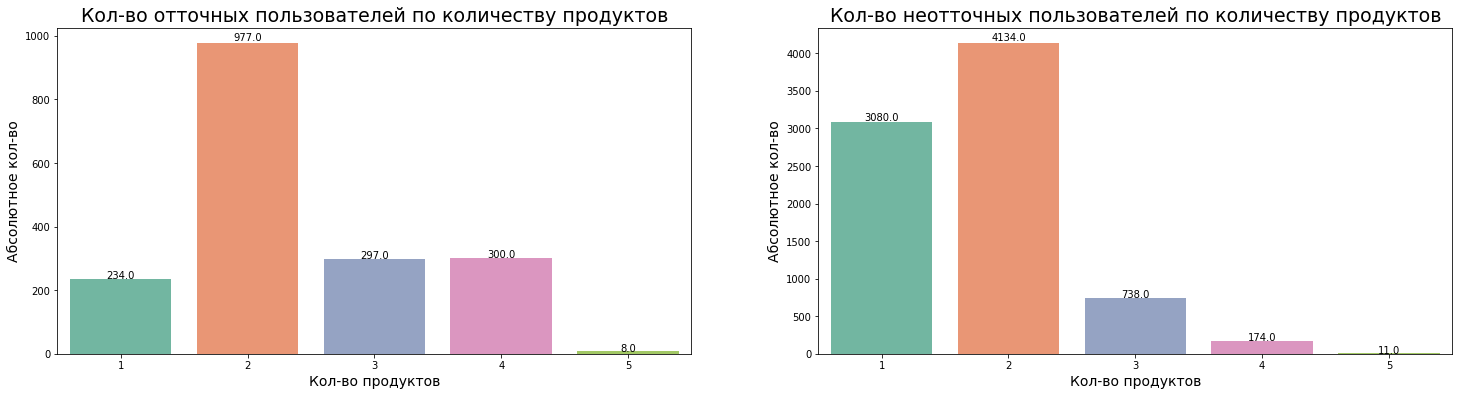

In [62]:
products_churn = data.query('churn == 1').groupby('products',as_index=False).agg(count=('user_id','count'))

products_churn_2 = data.query('churn == 0').groupby('products',as_index=False).agg(count=('user_id','count'))

fig, (ax1, ax2) = plt.subplots(1,ncols = 2,figsize=(25,6))

ax1 = sns.barplot(x='products', y='count', data=products_churn, ax=ax1)
ax1.set_title('Кол-во отточных пользователей по количеству продуктов',fontsize=19)
ax1.set_xlabel('Кол-во продуктов',fontsize=14)
ax1.set_ylabel('Абсолютное кол-во',fontsize=14)

show_values(ax1,1)

ax2 = sns.barplot(x='products', y='count', data=products_churn_2, ax=ax2)
ax2.set_title('Кол-во неотточных пользователей по количеству продуктов',fontsize=19)
show_values(ax2,1)

plt.xlabel('Кол-во продуктов',fontsize=14)
plt.ylabel('Абсолютное кол-во',fontsize=14)

    
plt.show()

По графику мы видим, что для отточных пользователей, как и у неотточных чаще всего встречаются пользователи с 2 продуктами. У отточных доля таких клиентов — 54%.

Однако среди отточных более распространено количество продуктов 3-4, в сравнении с неотточными, в то время как у неотточных выше доля пользователей с продуктами от 1-2. 

### Распределение по балансу

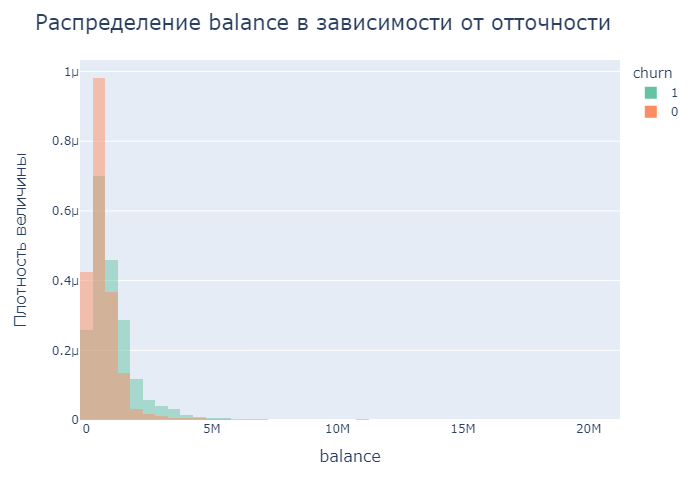

In [63]:
var_analysis(data, 'balance')

Напомним, что ранее мы убрали критические выбросы (более 21 миллиона), однако у нас остались аномалии, которые мешают детально проанализировать график. Для лучшего понимания приблизим график, рассмотрим отдельно значения до 95 квантиля и после.

In [64]:
#95 квантиль
var_95 = np.quantile(data[np.logical_not(data['balance'].isna())]['balance'],.95)

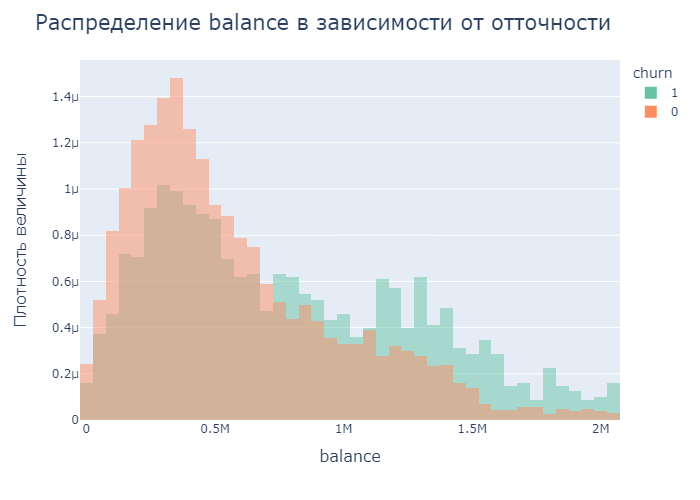

In [65]:
#распределение до 95 квантиля
var_analysis(data.query('balance < @var_95'), 'balance',100)

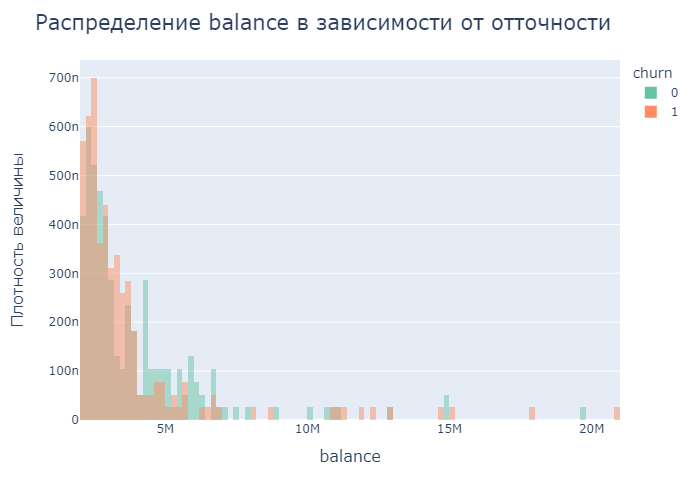

In [66]:
#распределение после 95 квантиля
var_analysis(data.query('balance > @var_95'), 'balance')

И для отточных, и для неотточных распределение баланса обладает общими трендами, наиболее характерный баланс (пик) лежит примерно в близком диапазоне. У отточных — 275-325 тысяч, у неотточных — 325-375 тысяч.

Баланс у неотточных на промежутке до 725 тысяч встречается чаще, а на промежутке от 725 тысяч до 4 млн мы видим, что у отточных такой баланс распространен чаще. Соответственно, этот промежуток будет нам интересен, у него потенциально большой процент отточности. 

Скорее всего, среди отточных выше доля более обеспеченных пользователей или тех, кто финансово подкован и лучше копит/сохраняет деньги. 

Учитывая график и ориентируясь на наиболее частотные значения у отточных пользователей, выделим следующие категории: 
**'низкий и средний баланс до 325к','средне-высокий баланс: 325-725к', 'высокий баланс: 725к-2.6м', 'крайне высокий баланс: более 2.6м'.**

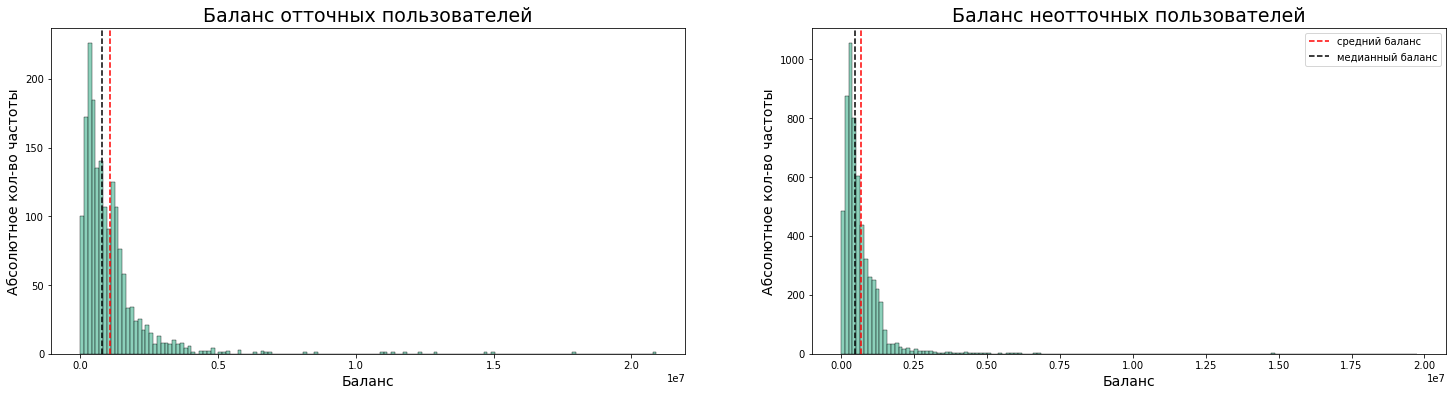

In [67]:
fig, (ax1, ax2) = plt.subplots(1,ncols = 2,figsize=(25,6))

ax1 = sns.histplot(x='balance',data=true_churn, bins = 150, ax=ax1)
ax1.set_title('Баланс отточных пользователей',fontsize=19)
ax1.set_xlabel('Баланс',fontsize=14)
ax1.set_ylabel('Абсолютное кол-во частоты',fontsize=14)
ax1.axvline(x=true_churn['balance'].mean(), color='r', linestyle='--',label="средний баланс")
ax1.axvline(x=true_churn['balance'].median(), color='k', linestyle='--',label="мединный баланс")

ax2 = sns.histplot(x='balance', data=false_churn,bins = 150, ax=ax2)
ax2.set_title('Баланс неотточных пользователей',fontsize=19)
ax2.axvline(x=false_churn['balance'].mean(), color='r', linestyle='--',label="средний баланс")
ax2.axvline(x=false_churn['balance'].median(), color='k', linestyle='--',label="медианный баланс")
ax2.set_xlabel('Баланс',fontsize=14)
ax2.set_ylabel('Абсолютное кол-во частоты',fontsize=14)

plt.legend()
plt.show()

### Распределение по собственности

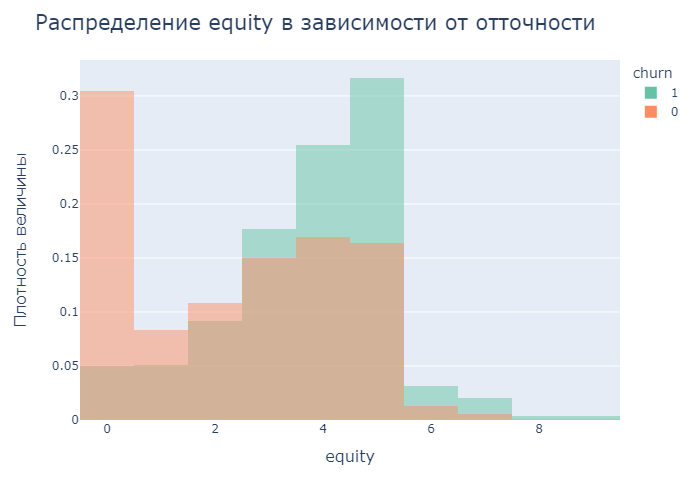

In [68]:
var_analysis(data, 'equity',10)

Среди отточных пользователей наиболее распространена оценка собственности в 5 пунктов (31%), среди не отточных — в 0 пунктов (30%). Скорее всего, оценка собственности связана с ее наличием, поэтому среди неотточных почти у трети пользователей вероятно нет собственности.

Также мы видим, что при сравнении в долевом отношении у отточных чаще, чем у неотточных встречается более высокая оценка собственности (от 3 и выше). 

Учитывая график и ориентируясь на наиболее частотные значения у отточных пользователей, выделим следующие категории: 
**'нет собственности', 'от 1 до 2', 'от 3 до 6', 'высокая оценка от 7 и выше'**.

### Распределение по зарплате

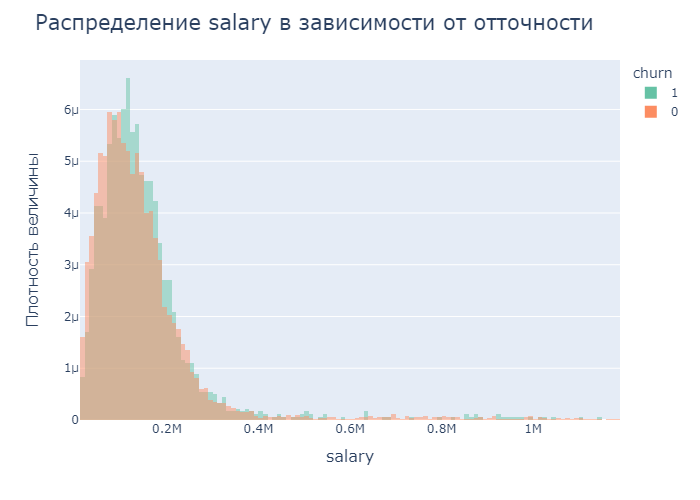

In [69]:
var_analysis(data, 'salary', 200)

Рассмотрим более детально выбросы:

In [70]:
#95 квантиль
var_95 = np.quantile(data['salary'],.95)

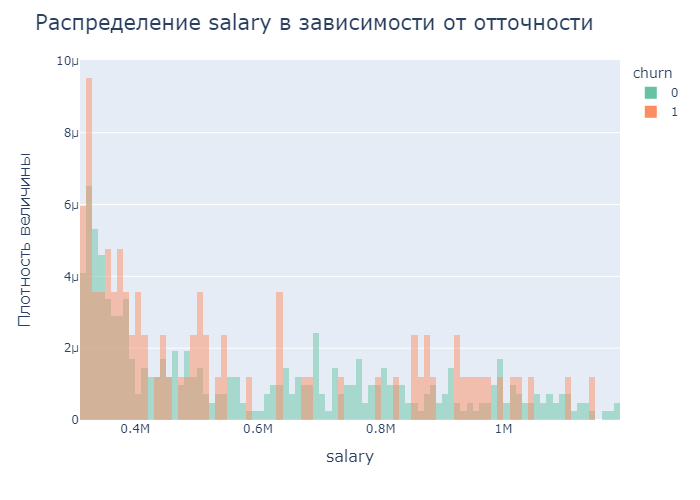

In [71]:
#распределение после 95 квантиля
var_analysis(data.query('salary > @var_95'), 'salary',100)

Опять же мы видим, что график распредедения зарплаты у отточных сдвинут вправо, то есть среди отточных доля людей с более высокой зарплатой (от 100 тысяч и выше) больше, чем у неотточных. Это соотносится и с графиками баланса и рейтинга — с этими переменными зарплата взаимосвязана, как мы ранее определили.

Самое частотное значение зарплаты у неотточных — 70-80 тысяч, у отточных пик — 110-120 тысяч. 
Среди отточных достаточно много людей с зарплатой выше среднего. 

Учитывая график и ориентируясь на наиболее частотные значения у отточных пользователей, выделим следующие категории: **'низкая и средняя зарплата до 100', 'зарплата от 100 до 220','зарплата от 220 до 520', 'крайне высокая зарплата более 520к'**

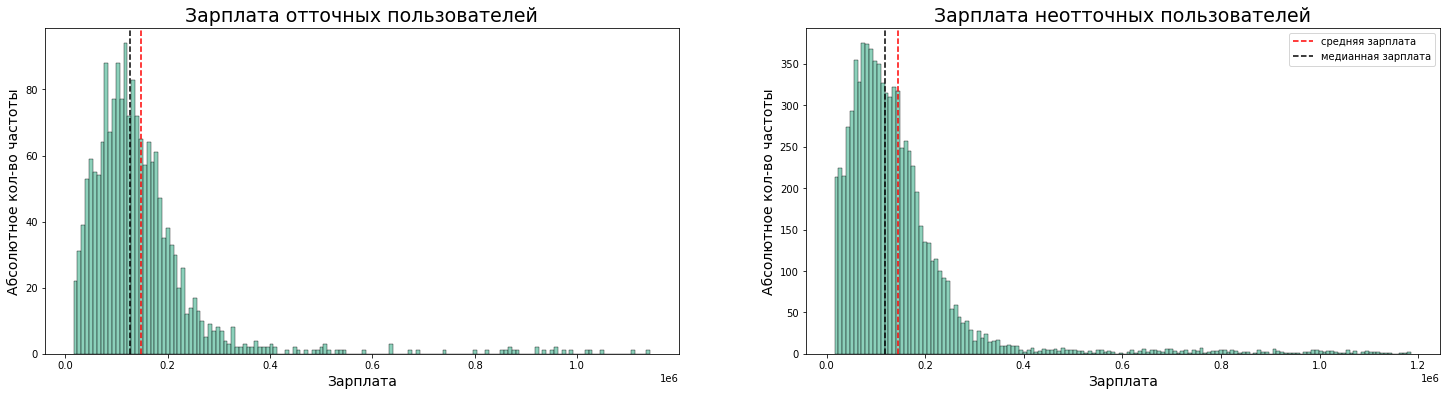

In [72]:
fig, (ax1, ax2) = plt.subplots(1,ncols = 2,figsize=(25,6))

ax1 = sns.histplot(x='salary',data=true_churn, bins = 150, ax=ax1)
ax1.set_title('Зарплата отточных пользователей',fontsize=19)
ax1.set_xlabel('Зарплата',fontsize=14)
ax1.set_ylabel('Абсолютное кол-во частоты',fontsize=14)
ax1.axvline(x=true_churn['salary'].mean(), color='r', linestyle='--',label="средняя зарплата")
ax1.axvline(x=true_churn['salary'].median(), color='k', linestyle='--',label="мединная зарплата")

ax2 = sns.histplot(x='salary', data=false_churn,bins = 150, ax=ax2)
ax2.set_title('Зарплата неотточных пользователей',fontsize=19)
ax2.axvline(x=false_churn['salary'].mean(), color='r', linestyle='--',label="средняя зарплата")
ax2.axvline(x=false_churn['salary'].median(), color='k', linestyle='--',label="медианная зарплата")
ax2.set_xlabel('Зарплата',fontsize=14)
ax2.set_ylabel('Абсолютное кол-во частоты',fontsize=14)

plt.legend()
plt.show()

### Распределение по наличию кредитной карты

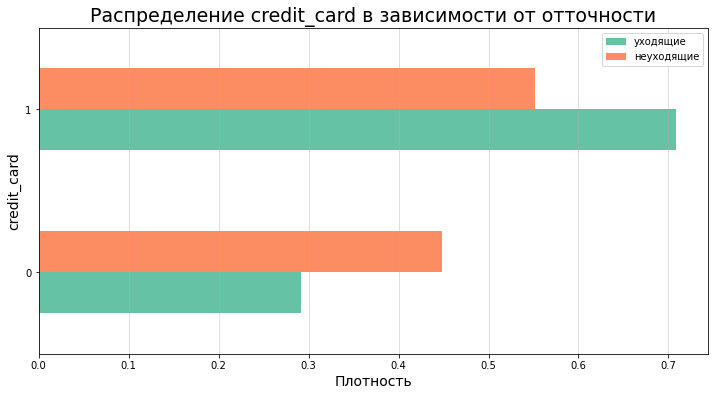

In [73]:
var_analysis(data, 'credit_card',2)

В обеих группах выше процент пользователей с кредитной картой. Однако среди отточных больше доля тех клиентов, у которых нет кредитной карты (45%), нежели чем у неотточных (29%). 

### Распределение по городам

Посмотрим на распределение пользователей по городам в зависимости от отточности в абсолютных количествах:

In [74]:
data.groupby(['city','churn'],as_index=False).agg(count=('user_id','count'))

,city,churn,count
0,Ростов,0,1151
1,Ростов,1,265
2,Рыбинск,0,2246
3,Рыбинск,1,436
4,Ярославль,0,4740
5,Ярославль,1,1115


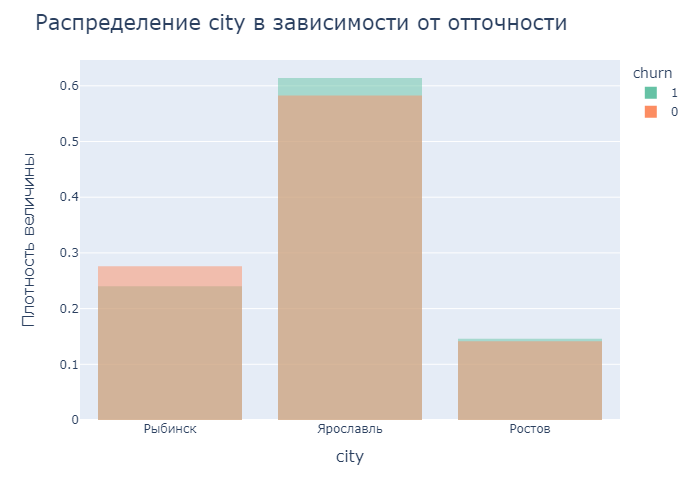

In [75]:
var_analysis(data, 'city',3)

Среди отточных выше доля пользователей из Ярославля и Ростова, по сравнению с неотточными. В Рыбинске у неотточных выше доля пользователей, чем у отточных. 

Как в целом по датасету, так и в обеих группах больше всего пользователей из Ярославля.

### Портрет типичного клиента, который склонен уходить из банка 

Итак мы определили признаки и их значения, связанные с повышенным оттоком пользователей. Суммируя все вышесказанное:

Типичный пользователь, склонный к уходу: мужчина из Ярославля с хотя бы одной активностью за месяц, высоким кредитным рейтингом от 850 до 900, от 25 до 35 лет, с 3-4 продуктами, но при этом среди продуктов нет кредитной карты, с достаточно высоким доходом (100-120 тысяч) и балансом счета от 725 тысяч с оценкой собственности в 3-5 пунктов. 

### Портрет типичного клиента, который не склонен уходить из банка 

Типичный пользователь, не склонный к уходу: женщина из Рыбинска, не совершавшая активности за месяц, с низким или средним кредитным рейтингом до 800 баллов, от 36 до 49 лет, с 1-2 продуктами, среди которых есть кредитная карта, с низким или средним доходом до 80 тысяч и балансом счета до 300 тысяч с оценкой собственности равной 0-2 пунктов. 

### Категоризируем данные по численным признакам — для дальнейшнего использования в сегментации

Категоризируем данные в столбцах score, age, balance, salary и equity на основе распределения признаков в контексте отточных пользователей. По графикам определили категории, где отточность выше и разбили на группы, опираясь на эти данные.

В столбце products дополнительную категоризацию делать не будем.

In [76]:
#категоризация рейтинга
data['score_cat'] = data['score']

for i, _ in data.iterrows():
    if data['score_cat'][i] < 820:
        data.loc[i, 'score_cat'] = 'менее 820 баллов'
        
    elif 900 >= data['score_cat'][i] >= 820:
        data.loc[i, 'score_cat'] = '820-900 баллов'
    
    elif 950 >= data['score_cat'][i] > 900:
        data.loc[i, 'score_cat'] = '901-950 баллов'
    
    else:
        data.loc[i, 'score_cat'] = 'высокий - более 950 баллов'

In [77]:
#категоризация возраста
data['age_cat'] = data['age']

for i, _ in data.iterrows():
    if data['age_cat'][i] <= 24:
        data.loc[i, 'age_cat'] = 'молодежь до 25 лет'
        
    elif 35 >= data['age_cat'][i] >= 25:
        data.loc[i, 'age_cat'] = 'зрелая молодежь 25-35 лет'
    
    elif 50 >= data['age_cat'][i] > 35:
        data.loc[i, 'age_cat'] = 'люди среднего возраста 36-50 лет'
    
    elif 60 >= data['age_cat'][i] > 50:
        data.loc[i, 'age_cat'] = 'средне-старший возраст 51-60 лет'
        
    else:
        data.loc[i, 'age_cat'] = 'старший возраст более 60 лет'

In [78]:
#категоризация баланса
data['balance_cat'] = data['balance']

for i, _ in data.iterrows():
    if data['balance_cat'][i] < 325000:
        data.loc[i, 'balance_cat'] = 'низкий и средний баланс до 325к'
        
    elif 725000 > data['balance_cat'][i] >= 325000:
        data.loc[i, 'balance_cat'] = 'средне-высокий баланс: 325-725к'
    
    elif 2600000 >= data['balance_cat'][i] >= 725000:
        data.loc[i, 'balance_cat'] = 'высокий баланс: 725к-2.6м'
    
    else:
        data.loc[i, 'balance_cat'] = 'крайне высокий баланс: более 2.6м'

In [79]:
#категоризация зарплаты
data['salary_cat'] = data['salary']

for i, _ in data.iterrows():
    if data['salary_cat'][i] < 100000:
        data.loc[i, 'salary_cat'] = 'низкая и средняя зарплата до 100'
        
    elif 220000 >= data['salary_cat'][i] >= 100000:
        data.loc[i, 'salary_cat'] = 'зарплата от 100 до 220'
    
    elif 520000 >= data['salary_cat'][i] > 220000:
        data.loc[i, 'salary_cat'] = 'зарплата от 220 до 520'
      
    else:
        data.loc[i, 'salary_cat'] = 'крайне высокая зарплата'
        

In [80]:
#категоризация по оценке собственности
data['equity_cat'] = data['equity']

for i, _ in data.iterrows():
    if data['equity_cat'][i] == 0:
        data.loc[i, 'equity_cat'] = 'нет собственности'
        
    elif 2>= data['equity_cat'][i] >= 1:
        data.loc[i, 'equity_cat'] = 'от 1 до 2'
    
    elif 6 >= data['equity_cat'][i] >= 3:
        data.loc[i, 'equity_cat'] = 'от 3 до 6'
    
    else:
        data.loc[i, 'equity_cat'] = 'высокая оценка от 7 и выше'

## Проверка гипотез

Мы проверим различия между отточными и неотточными по двух параметрам: доход и рейтинг. Так как пропусков в этих столбцах нет, выясним общие размеры выборок.

In [81]:
l = len(true_churn['salary'])
f'Размер выборки отточных: {l}'

'Размер выборки отточных: 1816'

In [82]:
l = len(false_churn['salary'])
f'Размер выборки неотточных: {l}'

'Размер выборки неотточных: 8137'

### Проверка гипотезы о различиях дохода между теми клиентами, которые ушли и теми, которые остались

- H0 (нулевая гипотеза): Статистически значимых различий в доходе между клиентами, которые ушли и остались, нет.
- Н1 (альтернативная гипотеза): Статистически значимые различия в доходе между клиентами, которые ушли и остались, есть.

Сначала проверим, **нормальное ли распределение** в двух выборках, используем для этого критерий Шапиро-Уилка

- H0: распределение нормально
- H1: распределение ненормально

In [83]:
#для отточных
pvalue = stats.shapiro(true_churn['salary'])[1]
if pvalue < 0.05:
    print (f'P-value равен: {pvalue}')
    print('Отвергаем нулевую гипотезу о нормальном распределении дохода отточных')
else:
    print (f'P-value равен: {pvalue}')
    print('Отвергнуть нулевую гипотезу о нормальном распределении дохода отточных не удалось')

P-value равен: 0.0
Отвергаем нулевую гипотезу о нормальном распределении дохода отточных


In [84]:
#для неотточных
pvalue = stats.shapiro(false_churn['salary'])[1]
if pvalue < 0.05:
    print (f'P-value равен: {pvalue}')
    print('Отвергаем нулевую гипотезу о нормальном распределении дохода неотточных')
else:
    print (f'P-value равен: {pvalue}')
    print('Отвергнуть нулевую гипотезу о нормальном распределении дохода неотточных не удалось')

P-value равен: 0.0
Отвергаем нулевую гипотезу о нормальном распределении дохода неотточных


Несмотря на то, что распределение ненормальное, у нас достаточно большие выборки, соответственно их выборочные средние должны быть нормально распределены. 

Выборка нетточных более чем в четыре раза больше выборки отточных.

Генеральные совокупности независимые (все пользователи уникальны).

**Поэтому мы проведем классический t-test с поправкой на равенство дисперсий.**

In [85]:
stat, pvalue = stats.ttest_ind(true_churn['salary'],false_churn['salary'],equal_var=False)
if pvalue < 0.05:
    print (f'P-value равен: {pvalue}')
    print('Отвергаем нулевую гипотезу об отсутствии статистически значимых различий в доходе между клиентами, которые ушли и остались')
else:
    print (f'P-value равен: {pvalue}')
    print('Отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в доходе между клиентами, которые ушли и остались, не удалось')

P-value равен: 0.5146954550108283
Отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в доходе между клиентами, которые ушли и остались, не удалось


Альтернативно проверим с помощью U-теста:

In [86]:
pvaue = stats.mannwhitneyu (true_churn['salary'],false_churn['salary'], use_continuity = True, alternative='two-sided')[1]
if pvalue < 0.05:
    print (f'P-value равен: {pvalue}')
    print('Отвергаем нулевую гипотезу об отсутствии статистически значимых различий в доходе между клиентами, которые ушли и остались')
else:
    print (f'P-value равен: {pvalue}')
    print('Отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в доходе между клиентами, которые ушли и остались, не удалось')

P-value равен: 0.5146954550108283
Отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в доходе между клиентами, которые ушли и остались, не удалось


Статистическая значимость различий в доходе между отточными и неотточными клиентами НЕ подтвердилась, не отвергаем нулевую гипотезу об отсутствии статистически значимых различий.

### Проверка гипотезы о различиях рейтинга между теми клиентами, которые ушли и теми, которые остались

- H0 (нулевая гипотеза): Статистически значимых различий в кредитном рейтинге между клиентами, которые ушли и остались, нет.
- Н1 (альтернативная гипотеза): Статистически значимые различия в кредитном рейтинге между клиентами, которые ушли и остались, есть.

Сначала проверим, **нормальное ли распределение** в двух выборках, используем для этого критерий Шапиро-Уилка

- H0: распределение нормально
- H1: распределение ненормально

In [87]:
#для отточных
pvalue = stats.shapiro(true_churn['score'])[1]
if pvalue < 0.05:
    print (f'P-value равен: {pvalue}')
    print('Отвергаем нулевую гипотезу о нормальном распределении рейтинга отточных')
else:
    print (f'P-value равен: {pvalue}')
    print('Отвергнуть нулевую гипотезу о нормальном распределении рейтинга отточных не удалось')

P-value равен: 0.00010032294812845066
Отвергаем нулевую гипотезу о нормальном распределении рейтинга отточных


In [88]:
#для неотточных
pvalue = stats.shapiro(false_churn['score'])[1]
if pvalue < 0.05:
    print (f'P-value равен: {pvalue}')
    print('Отвергаем нулевую гипотезу о нормальном распределении рейтинга неотточных')
else:
    print (f'P-value равен: {pvalue}')
    print('Отвергнуть нулевую гипотезу о нормальном распределении рейтинга неотточных не удалось')

P-value равен: 5.011079587491478e-26
Отвергаем нулевую гипотезу о нормальном распределении рейтинга неотточных


Здесь ситуация аналогична проверке 1 гипотезы: несмотря на то, что распределение ненормальное, у нас достаточно большие выборки, соответственно их выборочные средние должны быть нормально распределены. 

Выборка нетточных более чем в четыре раза больше выборки отточных.

Генеральные совокупности независимые (все пользователи уникальны).

**Поэтому мы проведем классический t-test с поправкой на равенство дисперсий.**

In [89]:
stat, pvalue = stats.ttest_ind(true_churn['score'],false_churn['score'],equal_var=False)
if pvalue < 0.05:
    print (f'P-value равен: {pvalue}')
    print('Отвергаем нулевую гипотезу об отсутствии статистически значимых различий в кредитном рейтинге между клиентами, которые ушли и остались')
else:
    print (f'P-value равен: {pvalue}')
    print('Отвергнуть нулевую гипотезу б отсутствии статистически значимых различий в кредитном рейтинге между клиентами, которые ушли и остались, не удалось')

P-value равен: 7.072236346150636e-38
Отвергаем нулевую гипотезу об отсутствии статистически значимых различий в кредитном рейтинге между клиентами, которые ушли и остались


Альтернативно проверим с помощью U-теста:

In [90]:
pvalue = stats.mannwhitneyu (true_churn['score'],false_churn['score'], use_continuity = False, alternative='two-sided')[1]
if pvalue < 0.05:
    print (f'P-value равен: {pvalue}')
    print('Отвергаем нулевую гипотезу об отсутствии статистически значимых различий в кредитном рейтинге между клиентами, которые ушли и остались')
else:
    print (f'P-value равен: {pvalue}')
    print('Отвергнуть нулевую гипотезу б отсутствии статистически значимых различий в кредитном рейтинге между клиентами, которые ушли и остались, не удалось')

P-value равен: 2.9390171458972375e-22
Отвергаем нулевую гипотезу об отсутствии статистически значимых различий в кредитном рейтинге между клиентами, которые ушли и остались


Статистическая значимость различий в кредитном рейтинге между отточными и неотточными клиентами подтвердилась.

# Сегменты клиентов, которые склонны уходить из банка 

Создадим функцию, которая сделает перебор признаков по всем переменным и составит тройки и четверки признаков, а также посчитает процент отточности в сегментах с признаками и их длину.

Несмотря на то что, с некоторыми признаками у отточности была обнаружена бОльшая корреляция, проверим все сочетания, поскольку корреляция не сильная.

Почему создаем тройки и четверки: если будем учитывать большее кол-во признаков, сегменты получатся менее большими, при этом при меньшем количестве признаков сегменты будут уже более размытыми и отделу маркетинга будет сложнее работать с ними.

In [91]:
#список столбцов для перебора
cat_columns = ['gender', 'products', 'credit_card', 'last_activity', 'city', 'score_cat', 'age_cat', 'balance_cat','salary_cat','equity_cat']

#общий уровень отточности в датасете содержится в переменной churn_rate

In [92]:
#создадим функцию, которая переберет уникальные тройки или четверки значений признаков 
#и отберет по ним сегменты датасета с процентом отточности больше, чем во всем датасете и размером не менее 500-600 пользователей
def create_segments(data, 
                    cat_columns, 
                    n, #3 или 4
                    percent_churn, #общий процент отточности
                    segment_shape #минимальный размер сегмента
                    ):
    
    col_comb_tupl = list(itertools.combinations(cat_columns, r=n))
    col_comb_list = [list(value) for value in col_comb_tupl]
    
    values_for_df = []
    
    if n==3:
    
        for i in range(len(col_comb_list)):
        
            unique_values_list = [data[col_comb_list[i]].iloc[:, 0].unique(), data[col_comb_list[i]].iloc[:, 1].unique(), 
                data[col_comb_list[i]].iloc[:, 2].unique()]
        
            values_combinations = list(itertools.product(*unique_values_list))
            values_combinations = [list(value) for value in values_combinations]
            
        
            for n in range(len(values_combinations)):
                dt = data.loc[(data[col_comb_list[i][0]] == values_combinations[n][0]) & 
                          (data[col_comb_list[i][1]] == values_combinations[n][1]) &
                        (data[col_comb_list[i][2]] == values_combinations[n][2])
                        ]
           
                dt_churn_rate = dt[dt['churn']== 1]['churn'].count()/dt['churn'].count()
                  
                len_dt = len(dt['user_id'])
        
                if dt_churn_rate > percent_churn and len_dt > segment_shape:
                    values_for_df.append([col_comb_list[i], values_combinations[n], dt_churn_rate, len_dt])

    if n==4:
        for i in range(len(col_comb_list)):
        
            unique_values_list = [data[col_comb_list[i]].iloc[:, 0].unique(), data[col_comb_list[i]].iloc[:, 1].unique(), 
                data[col_comb_list[i]].iloc[:, 2].unique(),data[col_comb_list[i]].iloc[:, 3].unique()]
        
            values_combinations = list(itertools.product(*unique_values_list))
            values_combinations = [list(value) for value in values_combinations]
            

            for n in range(len(values_combinations)):
                dt = data.loc[(data[col_comb_list[i][0]] == values_combinations[n][0]) & 
                          (data[col_comb_list[i][1]] == values_combinations[n][1]) &
                        (data[col_comb_list[i][2]] == values_combinations[n][2]) &
                        (data[col_comb_list[i][3]] == values_combinations[n][3])
                        ]
                          
                dt_churn_rate = dt[dt['churn']== 1]['churn'].count()/dt['churn'].count()
                  
                len_dt = len(dt['user_id'])
        
                if dt_churn_rate > percent_churn and len_dt > segment_shape:
                    values_for_df.append([col_comb_list[i], values_combinations[n], dt_churn_rate, len_dt])

    return values_for_df

In [93]:
values_for_df = create_segments(data, cat_columns, 3, churn_rate, 550)
values_for_df_2 = create_segments(data, cat_columns, 4, churn_rate, 550)

In [94]:
#датафрейм, где сохраним рез-ты перебора троек и четверок
pd.set_option('max_colwidth', 100)
combinations_df_3 = pd.DataFrame(values_for_df , columns=['values','combination','churn_rate','length'])
combinations_df_4 = pd.DataFrame(values_for_df_2, columns=['values','combination','churn_rate','length'])
combinations_df = pd.concat([combinations_df_3,combinations_df_4]).sort_values(by=["churn_rate",'length'],ascending=False)

#финальный датасет с лидерами по проценту отточности в сегменте
winners = combinations_df.head(15).reset_index(drop=True)
winners

,values,combination,churn_rate,length
0,"[gender, last_activity, balance_cat, equity_cat]","[М, 1, высокий баланс: 725к-2.6м, от 3 до 6]",0.586690,571
1,"[gender, last_activity, balance_cat]","[М, 1, высокий баланс: 725к-2.6м]",0.584906,636
2,"[last_activity, balance_cat, salary_cat, equity_cat]","[1, высокий баланс: 725к-2.6м, зарплата от 100 до 220, от 3 до 6]",0.567863,641
3,"[gender, last_activity, score_cat, equity_cat]","[М, 1, 820-900 баллов, от 3 до 6]",0.560178,673
4,"[credit_card, last_activity, balance_cat]","[0, 1, высокий баланс: 725к-2.6м]",0.556106,606
5,"[last_activity, city, balance_cat, equity_cat]","[1, Ярославль, высокий баланс: 725к-2.6м, от 3 до 6]",0.555896,653
6,"[last_activity, balance_cat, salary_cat]","[1, высокий баланс: 725к-2.6м, зарплата от 100 до 220]",0.553719,726
7,"[last_activity, score_cat, balance_cat, equity_cat]","[1, 820-900 баллов, высокий баланс: 725к-2.6м, от 3 до 6]",0.547468,632
8,"[last_activity, score_cat, balance_cat]","[1, 820-900 баллов, высокий баланс: 725к-2.6м]",0.546377,690
9,"[last_activity, score_cat, salary_cat, equity_cat]","[1, 820-900 баллов, зарплата от 100 до 220, от 3 до 6]",0.538117,669


## Описание сегментов и рекомендации по ним 

In [95]:
#функция для вывода информации о сегменте
def seg_info(data, num):
    len_ = data['length'][num]
    pr = round(data['churn_rate'][num],3)
    return len_,pr

### Сегмент 1:

- Мужчины
- С хотя бы одной активностью в течение месяца
- С высоким балансом от 725 тысяч до 2.6 миллионов

P.S. не брали первый сегмент из получившегося рейтинга, поскольку доля оттока в нем не сильно больше, но размер меньше

In [96]:
len_,pr = seg_info(winners, 1)

print(f'Размер сегмента:{len_}')
print(f'Доля отточных пользователей в сегменте:{pr}')

Размер сегмента:636
Доля отточных пользователей в сегменте:0.585


**Рекомендации:** При работе с первым сегментом с высокой отточностью рекомендуем обратить внимание на специальные предложения, которые могли бы заинтересовать обеспеченных мужчин, активных клиентов банка. 

Например, предложить специализированные акции, подарки от тематических партнеров (с уклоном в мужские интересы: спорт, путешествия, техника и т.д.). Так как эти клиенты хранят достаточно большую сумму на счету, по возможности стоит улучшить соответствующие условия, например, предложить повышение процента на остаток, если это возможно, или, например, предложить персональные предложения, которые повысят удобство пользованием банком (персональный менеджер, еженедельная рассылка с закрытыми предложениями и пр.). Вероятно, этим клиентам также будут интересны бизнес-продукты.

Необходимо выяснить возможные причины их ухода: возможно, появился конкурент с более выгодными условиями хранения средств, а активные пользователи финансово подкованы и следят за рынком, возможно, не хватает удобного приложения, по которому легко отслеживать происходящее со счетом и возможно получать быструю поддержку от банка.

Скорее всего, эти клиенты достаточно лояльны к банку, однако не удовлетворены качеством услуг или продуктов.

### Сегмент 2:

- Пользователи с хотя бы одной активностью в течение месяца
- С высоким балансом от 725 тысяч до 2.6 миллионов
- С зарплатой от 100 до 220 тысяч
- С оценкой собственности от 3 до 6 баллов

In [97]:
len_,pr = seg_info(winners, 2)

print(f'Размер сегмента:{len_}')
print(f'Доля отточных пользователей в сегменте:{pr}')

Размер сегмента:641
Доля отточных пользователей в сегменте:0.568


**Рекомендации:** Второй сегмент с высокой отточностью — это люди уверенного среднего класса, скорее всего, они знают цену деньгам и финансово грамотны, более того, у них достаточно высокая оценка собственности, а это также подтверждает предположение о том, что эти пользователи грамотно распоряжаются деньгами. Эти клиенты ценны для банка.

Так как эти клиенты хранят достаточно большую сумму на счету, можно улучшить соответствующие условия такого рода продуктов, например, предложить повышение процента на остаток, если это возможно, или, например, предложить персональные предложения, которые повысят удобство пользованием банком (персональный менеджер, еженедельная рассылка с закрытыми предложениями и пр.). Если менять продукт нельзя, предложить этим пользователям систему бонусов или персональные скидки от партнеров в выбранных категориях, повышенный кэшбек. 

Скорее всего, этим клиентам важна надежность и выгодность хранения средств, вероятно, они вкладываются в покупку собственности, но при этом доход позволяет делать это только с помощью накоплений. Можно предложить персональные продукты, связанные с накоплением средств. 

### Сегмент 3:

- Мужчины
- С хотя бы одной активностью в течение месяца
- С кредитным рейтингом 820-900 баллов
- С оценкой собственности от 3 до 6 баллов

In [98]:
len_,pr = seg_info(winners, 3)

print(f'Размер сегмента:{len_}')
print(f'Доля отточных пользователей в сегменте:{pr}')

Размер сегмента:673
Доля отточных пользователей в сегменте:0.56


**Рекомендации:** При работе с этим сегментом также рекомендуется обратить внимание на специализированные акции, подарки от тематических партнеров (с уклоном в мужские интересы: спорт, путешествия, техника и т.д.). Это может повысить лояльность сегмента.

Однако также необходимо более глубинная работа с продуктами — предложение более качественных и выгодных условий.

### Сегмент 4:

- Пользователи с хотя бы одной активностью в течение месяца
- С высоким балансом от 725 тысяч до 2.6 миллионов
- Без кредитной карты

In [99]:
len_,pr = seg_info(winners, 4)

print(f'Размер сегмента:{len_}')
print(f'Доля отточных пользователей в сегменте:{pr}')

Размер сегмента:606
Доля отточных пользователей в сегменте:0.556


**Рекомендации:** При работе с четвертым сегментом можно предложить открытие кредитной карты на более выгодных условиях (повышенный кешбек, подарки партнеров и т.д.). 

Эти пользователи активны, имеют достаточно высокие накопления, поэтому они скорее всего, лояльны к банку, но их не устраивают условия или обслуживание. Возможно, им не хватает удобного приложения, по которому легко отслеживать происходящее со счетом и возможно получать быструю поддержку от банка.

## Общие выводы для заказчика

- Среди уходящих пользователей большинство — активные клиенты, с хорошим доходом и достаточно большими накоплениями на счету. Это активные и обеспеченные пользователи, но при этом они хотят уйти из банка. 

- Более того, если тенденция, что к оттоку склонны пользователи с большим количеством продуктов. 

- Скорее всего, только лишь маркетинговыми предложениями ситуацию не исправить. Необходимо провести более глубинный анализ и выявить причины недовольства пользователей: возможно, страдает обслуживание, возможно не хватает удобства (например, качественного приложения, чат-бота), также дело может быть в продуктах, однако учитывая то, что у большинства отточных на счету большая сумма, можно сказать, что они были лояльны к банку, но что-то изменилось. 

- Необходимо выяснить, менялись ли основные продукты, возможно, условия стали сильно менее выгодными, чем у конкурентов, или на горизонте появился активный конкурент с выгодными условиями. В любом случае, необходимо дополнительное исследование, а также опрос пользователей отточных сегментов и дальшейшее улучшение продуктов. Например, можно ввести анкетирование-опрос, в случае если клиент пишет заявление на уход. 

## Подготовка презентации

Ссылка на презентацию по проекту: https://drive.google.com/file/d/1G2lZ5eT1ZDwimnz28LZm8Zu0TzogoBap/view?usp=sharing 

## Подготовка дашборда

Ссылка на дашборд: https://public.tableau.com/app/profile/sasha.shepelyuk/viz/___16888995138150/Dashboard2?publish=yes